In [1]:
# Import from local package
import sys
sys.path.append('../model')

from tqdm import tqdm_notebook as progress_bar

import torch

In [2]:
from models import SimpleCNN3Layer as Model
from collectdata import DataCollector
from plots import plot_truth_vs_predict
from efficiency import efficiency, ValueSet
from training import select_gpu

In [3]:
# Device configuration
device = select_gpu(1)
#device = torch.device("cpu")

1 available GPUs (initially using device 0):
  0 Tesla P100-PCIE-16GB


In [4]:
collector = DataCollector(
    "/data/schreihf/PvFinder/Aug_15_140000.npz",
    120_000, 10_000)

Loaded /data/schreihf/PvFinder/Aug_15_140000.npz in 9.149 s
Samples in Training: 120000 Validation: 10000 Test: 10000


In [5]:
validation = collector.get_validation(1, device=device)

Constructing dataset on cuda:0 took 3.455 s


In [6]:
model = Model().to(device)

In [6]:
model.load_state_dict(torch.load('../model/output3/20180815_120000_3layer_30.pyt'))
model.eval()

SimpleCNN3Layer(
  (conv1): Conv1d(1, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3dropout): Dropout(p=0.35)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)

In [7]:
%%time
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

CPU times: user 196 ms, sys: 114 ms, total: 310 ms
Wall time: 310 ms


In [8]:
%%time
total = ValueSet(0,0,0,0)

for output, label in zip(outputs, labels):
    total += efficiency(output, label, 1e-2, 5.)

CPU times: user 175 ms, sys: 1.2 ms, total: 177 ms
Wall time: 175 ms


In [9]:
print(total.pretty())

Real PVs in validation set: 55,048
Successes: Either 44,143 or 44,295, depending on how you count.
Missed True PVs: 10,905
False Positives: 1,921
Efficency of detecting real PVs: 80.19%
False positive rate: 3.49%


# Some examples of the counting algorithm:

In [11]:
for i in range(20):
    result = efficiency(outputs[i], labels[i], 1e-2, 5.)
    print(result)

Total: 4, Successes: 3, MT: 1, FP: 1
Total: 8, Successes: 7, MT: 1, FP: 0
Total: 4, Successes: 2, MT: 2, FP: 1
Total: 6, Successes: 4, MT: 2, FP: 0
Total: 6, Successes: 5, MT: 1, FP: 0
Total: 8, Successes: 7, MT: 1, FP: 0
Total: 6, Successes: 5, MT: 1, FP: 0
Total: 5, Successes: 3, MT: 2, FP: 0
Total: 6, Successes: 3, MT: 3, FP: 0
Total: 4, Successes: 2, MT: 2, FP: 0
Total: 4, Successes: 3, MT: 1, FP: 0
Total: 4, Successes: 4, MT: 0, FP: 1 (Sp: 5)
Total: 6, Successes: 6, MT: 0, FP: 0
Total: 7, Successes: 6, MT: 1, FP: 0
Total: 1, Successes: 1, MT: 0, FP: 0
Total: 1, Successes: 1, MT: 0, FP: 0
Total: 5, Successes: 4, MT: 1, FP: 0
Total: 2, Successes: 2, MT: 0, FP: 0
Total: 6, Successes: 6, MT: 0, FP: 1
Total: 6, Successes: 6, MT: 0, FP: 0


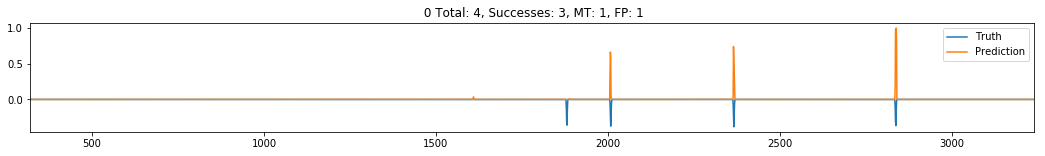

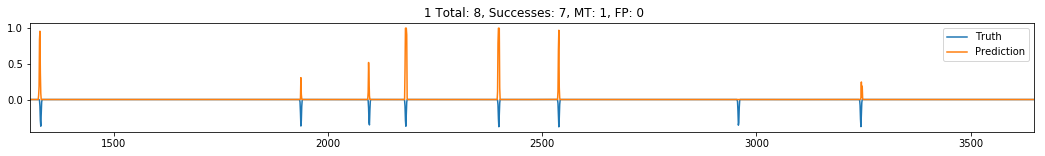

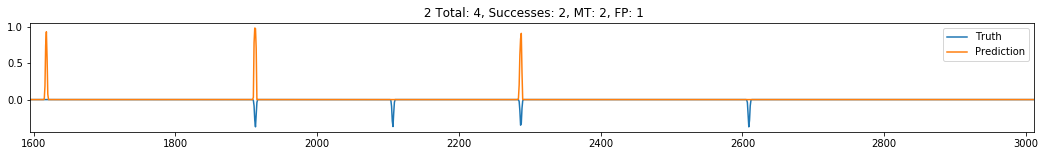

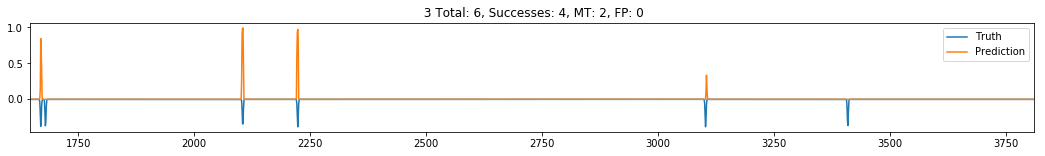

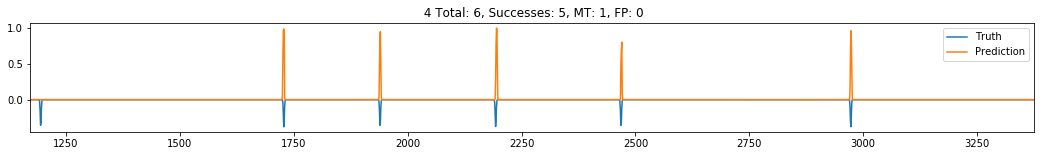

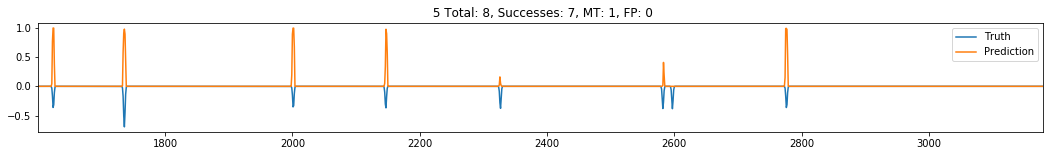

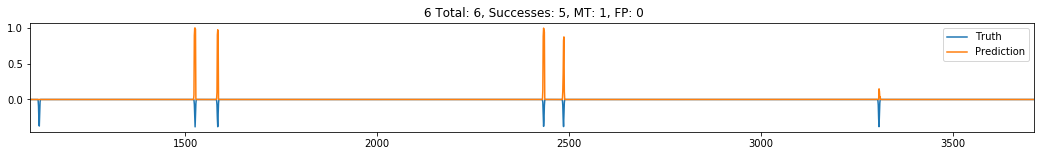

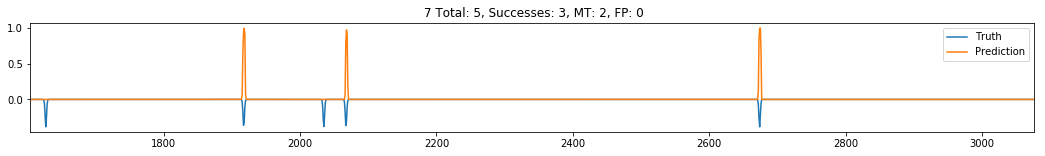

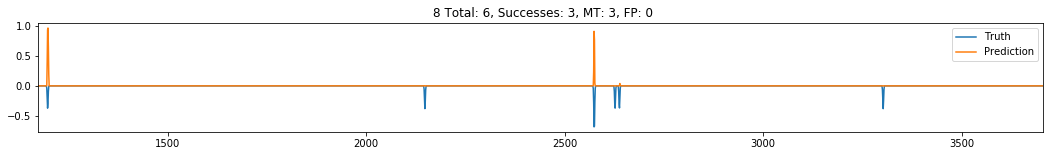

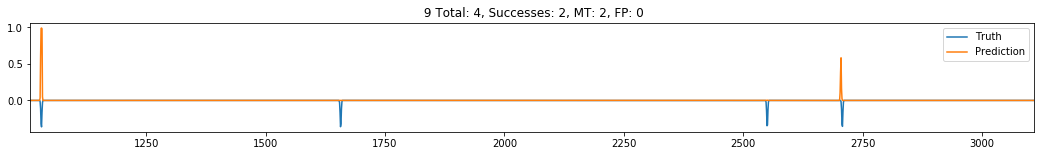

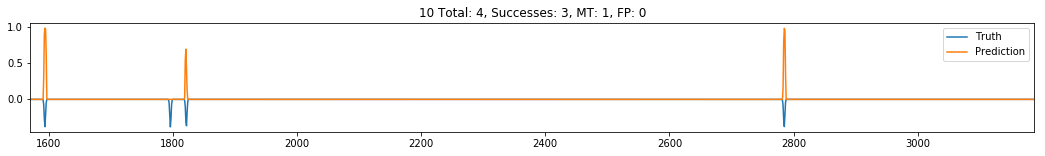

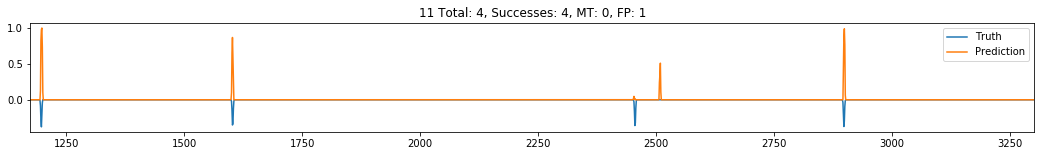

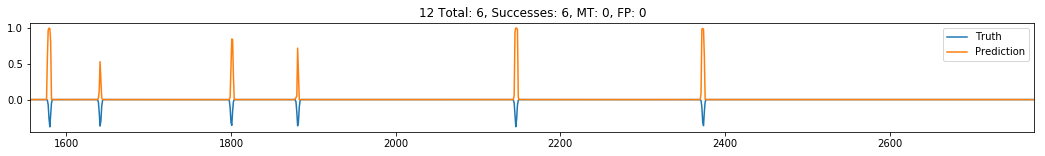

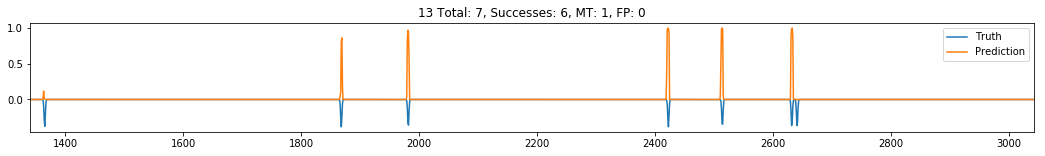

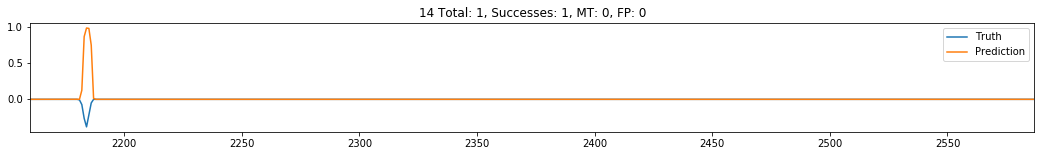

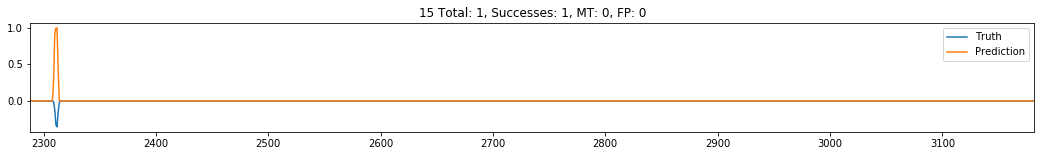

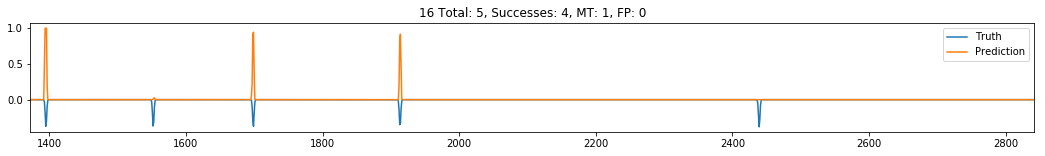

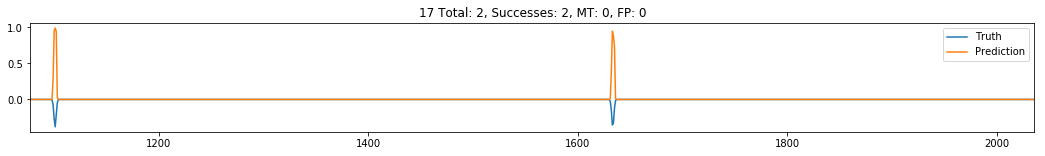

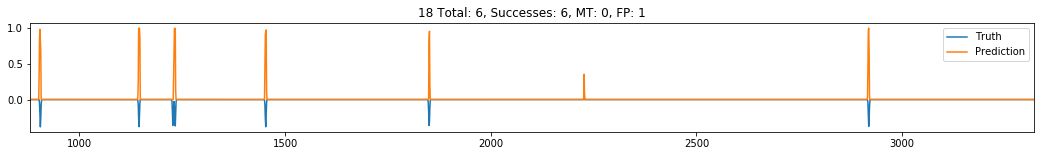

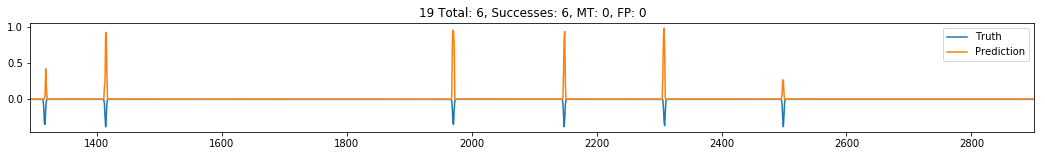

In [12]:
for i in range(20):
    S, Sp, MT, FP = efficiency(outputs[i], labels[i], 2e-2, 5.)
    result = describe(i, S, Sp, MT, FP)
    ax = plot_truth_vs_predict(outputs[i], labels[i])
    ax.set_title(str(result))